In [95]:
%config IPCompleter.use_jedi = False

In [1]:
import os
import json
import numpy as np
import requests
import time
import cv2
import base64
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.display import display, HTML
from k12libs.utils.nb_easy import RACEURL

In [33]:
display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

In [34]:
API_INFERENCE = f'{RACEURL}/raceai/framework/inference'
API_INFERENCE

'http://116.85.5.40:9119/raceai/framework/inference'

In [35]:
API_POPMSG = f'{RACEURL}/raceai/private/popmsg'
API_POPMSG 

'http://116.85.5.40:9119/raceai/private/popmsg'

In [36]:
MODEL_TASK = 'zmq.yolov5.rpc.x.inference'
MSGKEY = 'zmq.yolo.rpc.test'
CONF_THRES = 0.25
IOU_THRES = 0.45
IMG_ROOT = '/raceai/data/datasets/retail_product_checkout'

In [37]:
LABEL_NAMES = ['优乐美红豆奶茶', '农夫山泉矿泉水', '可口可乐', '芬达橙味', '雪碧', '王老吉']
SAMPLE_FILES = [
    'images/train/6921168509256_camera0-22.jpg',
    'images/train/6926475206263_camera0-13.jpg',
    'images/train/6928804010220_camera0-35.jpg',
    'images/train/6928804011173_camera0-11.jpg',
    'images/train/6928804011326_camera0-37.jpg',
    'images/train/6956367338680_camera0-14.jpg'
]

In [38]:
SAMPLE_FILES = [
    "rpc_test_0.jpeg",
    "rpc_test_1.jpg",
    "rpc_test_2.jpeg",
    "rpc_test_3.jpg",
    "rpc_test_4.jpeg",
    "rpc_test_8.jpeg",
]
IMG_ROOT = '/raceai/data/tmp/rpc'

CONF_THRES = 0.25
IOU_THRES = 0.45

In [103]:
# SAMPLE_FILES = ['https://custom-data.s3.didiyunapi.com/sceneobj/1/1/3/b1c24cf9c577bdaccb96550828f6e020.jpeg']
# SAMPLE_FILES = ['https://ss2.bdstatic.com/70cFvnSh_Q1YnxGkpoWK1HF6hhy/it/u=3314365013,1102905193&fm=26&gp=0.jpg']
# SAMPLE_FILES = ['http://5b0988e595225.cdn.sohucs.com/images/20200303/fe40058ce6e447bcafa3c273c859257d.jpeg']
# IMG_ROOT = ''
# CONF_THRES = 0.01
# IOU_THRES = 0.02

## 调试

In [39]:
rawdata = '''{
    "task": "%s",
    "cfg": {
        "pigeon": {
            "msgkey": "%s",
            "user": "1",
            "uuid": "100"
        },
        "data": {
            "class_name": "raceai.data.process.PathListDataLoader",
            "params": {
                "data_source": %s,
                "dataset": {
                    "class_name": "raceai.data.RawRaceDataset",
                    "params": {
                        "data_prefix": "%s"
                    }
                }
            }
        },
        "nms":{
            "conf_thres": %.2f,
            "iou_thres": %.2f
        }
    }
}''' % (MODEL_TASK, MSGKEY, SAMPLE_FILES, IMG_ROOT, CONF_THRES, IOU_THRES)

### 输入

只需要修改: `data_source` 和 `data_prefix`

In [40]:
print(rawdata)

{
    "task": "zmq.yolov5.rpc.x.inference",
    "cfg": {
        "pigeon": {
            "msgkey": "zmq.yolo.rpc.test",
            "user": "1",
            "uuid": "100"
        },
        "data": {
            "class_name": "raceai.data.process.PathListDataLoader",
            "params": {
                "data_source": ['rpc_test_0.jpeg', 'rpc_test_1.jpg', 'rpc_test_2.jpeg', 'rpc_test_3.jpg', 'rpc_test_4.jpeg', 'rpc_test_8.jpeg'],
                "dataset": {
                    "class_name": "raceai.data.RawRaceDataset",
                    "params": {
                        "data_prefix": "/raceai/data/tmp/rpc"
                    }
                }
            }
        },
        "nms":{
            "conf_thres": 0.25,
            "iou_thres": 0.45
        }
    }
}


In [41]:
reqdata = eval(rawdata)
json.loads(requests.get(url=f'{API_POPMSG}?key={MSGKEY}').text)
json.loads(requests.post(url=API_INFERENCE, json=reqdata).text)
time.sleep(3)

In [42]:
resdata = json.loads(requests.get(url=f'{API_POPMSG}?key={MSGKEY}').text)
resdata

[{'pigeon': {'msgkey': 'zmq.yolo.rpc.test', 'user': '1', 'uuid': '100'},
  'task': 'zmq.yolov5.rpc.x.inference',
  'errno': 0,
  'result': [{'image_path': 'rpc_test_0.jpeg',
    'predict_box': [{'label': 1,
      'conf': '0.252',
      'xyxy': [112, 65, 214, 404]}]},
   {'image_path': 'rpc_test_1.jpg', 'predict_box': []},
   {'image_path': 'rpc_test_2.jpeg',
    'predict_box': [{'label': 3,
      'conf': '0.482',
      'xyxy': [77, 35, 129, 189]}]},
   {'image_path': 'rpc_test_3.jpg',
    'predict_box': [{'label': 2,
      'conf': '0.375',
      'xyxy': [94, 90, 223, 489]}]},
   {'image_path': 'rpc_test_4.jpeg',
    'predict_box': [{'label': 4,
      'conf': '0.372',
      'xyxy': [241, 72, 403, 550]}]},
   {'image_path': 'rpc_test_8.jpeg', 'predict_box': []}],
  'running_time': 0.36}]

['优乐美红豆奶茶', '农夫山泉矿泉水', '可口可乐', '芬达橙味', '雪碧', '王老吉']


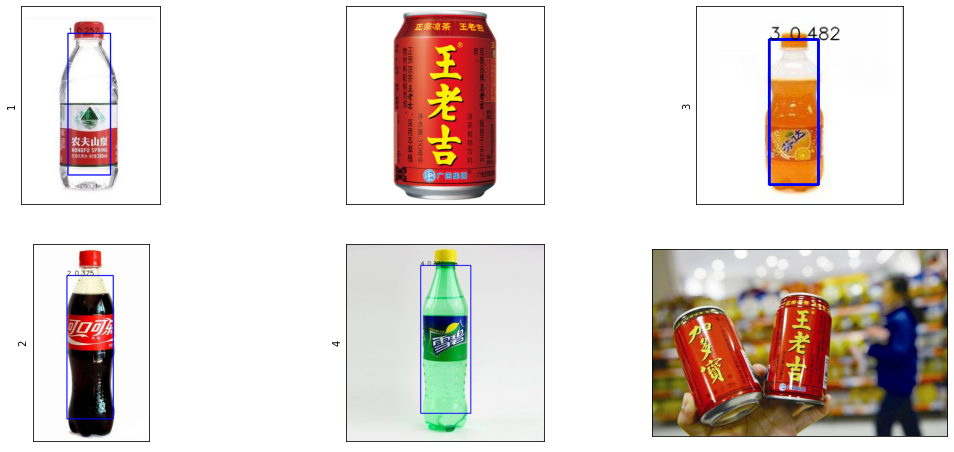

In [43]:
plt.figure(figsize=(18, 8))

nrow, ncol = 2, 3
max_show = nrow*ncol
plt.axis('off');
for data in resdata:
    if 'result' not in data:
        continue
    for i, result in enumerate(data['result'], 1):
        if i > max_show:
            break
        image_path = f'{IMG_ROOT}/{result["image_path"]}'
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        for item in result['predict_box']:
            xyxy = tuple(item['xyxy'])
            cv2.rectangle(image, xyxy[0:2], xyxy[2:], (0, 0, 255), 2)
            cv2.putText(image, f'{item["label"]} {item["conf"]}', xyxy[0:2], 0, 0.6, (0, 0, 0), lineType=cv2.LINE_AA)
        plt.subplot(nrow, ncol, i)
        plt.xticks([])
        plt.yticks([])
        if len(result['predict_box']) > 0:
            plt.ylabel(item['label'])
        plt.imshow(image)
print(LABEL_NAMES)

## 单张Base64

In [110]:
# test_face1 = '/hzcsk12/hzcsnote/assets/images/test_rpc.jpg'
test_face1 = '/hzcsk12/hzcsnote/assets/rpc/rpc_test_0.jpeg'
test_image1 = cv2.cvtColor(cv2.imread(test_face1), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.xticks([])
plt.yticks([])
plt.imshow(test_image1);

error: OpenCV(4.5.1) /tmp/pip-req-build-1syr35c1/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
def img2b64(path):
    with open(path, 'rb') as fr:
        b4data = base64.b64encode(fr.read()).decode()
    return b4data

reqdata = '''{
    "task": "%s",
    "cfg": {
        "pigeon": {
            "msgkey": "%s",
            "user": "1",
            "uuid": "100"
        },
        "data": {
            "class_name": "raceai.data.process.Base64DataLoader",
            "params": {
                "data_source": "%s",
                "dataset": {
                    "class_name": "raceai.data.RawRaceDataset",
                    "params": {}
                }
            }
        },
        "nms":{
            "conf_thres": %.2f,
            "iou_thres": %.2f
        }
    }
}''' % (MODEL_TASK, MSGKEY, img2b64(test_face1), 0.1, IOU_THRES)

reqdata = eval(reqdata)
json.loads(requests.get(url=f'{API_POPMSG}?key={MSGKEY}').text)
json.loads(requests.post(url=API_INFERENCE, json=reqdata).text)
time.sleep(3)

In [ ]:
resdata = json.loads(requests.get(url=f'{API_POPMSG}?key={MSGKEY}').text)
print(resdata)
for data in resdata:
    for result in data['result']:
        for item in result['predict_box']:
            xyxy = tuple(item['xyxy'])
            cv2.rectangle(test_image1, xyxy[0:2], xyxy[2:], (255, 255, 255), 4)
            cv2.putText(test_image1, item['conf'], xyxy[0:2], 0, 0.6, (0, 0, 0), lineType=cv2.LINE_AA)
        
plt.figure(figsize=(12, 8))
plt.imshow(test_image1)
plt.axis('off');

## 批量探测

In [ ]:
with open(f'{IMG_ROOT}/files.txt', 'r') as fr:
    samplefiles = fr.read().split('\n')[:-2]

In [ ]:
image_files = random.choices(samplefiles, k=20)

reqdata = '''{
    "task": "%s",
    "cfg": {
        "pigeon": {
            "msgkey": "%s",
            "user": "1",
            "uuid": "100"
        },
        "data": {
            "class_name": "raceai.data.process.PathListDataLoader",
            "params": {
                "data_source": %s,
                "dataset": {
                    "class_name": "raceai.data.RawRaceDataset",
                    "params": {
                        "data_prefix": "%s"
                    }
                }
            }
        },
        "nms":{
            "conf_thres": %.2f,
            "iou_thres": %.2f
        }
    }
}''' % (MODEL_TASK, MSGKEY, json.dumps(image_files), IMG_ROOT, CONF_THRES, IOU_THRES)

reqdata = eval(reqdata)
json.loads(requests.get(url=f'{API_POPMSG}?key={MSGKEY}').text)
json.loads(requests.post(url=API_INFERENCE, json=reqdata).text)
time.sleep(5)

In [ ]:
plt.figure(figsize=(20, 16))
resdata = json.loads(requests.get(url=f'{API_POPMSG}?key={MSGKEY}').text)
# print(resdata)
for data in resdata:
    for i, result in enumerate(data['result']):
        image_path = f'{IMG_ROOT}/{result["image_path"]}'
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        for item in result['predict_box']:
            xyxy = tuple(item['xyxy'])
            cv2.rectangle(image, xyxy[0:2], xyxy[2:], (255, 255, 255), 10)
            cv2.putText(image, item['conf'], xyxy[0:2], 0, 0.6, (0, 0, 0), lineType=cv2.LINE_AA)
        plt.subplot(5, 4, i+1)
        plt.imshow(image)
        plt.axis('off');

## 封装测试

In [ ]:
def test_yolo(task, msgkey, testimgs, conf=0.25, iou=0.45, show=True):
    ncol = 5
    nrow = (len(testimgs) + ncol - 1) // ncol
    
    reqdata = '''{
        "task": "%s",
        "cfg": {
            "pigeon": {
                "msgkey": "%s",
                "user": "1",
                "uuid": "100"
            },
            "data": {
                "class_name": "raceai.data.process.PathListDataLoader",
                "params": {
                    "data_source": %s,
                    "dataset": {
                        "class_name": "raceai.data.RawRaceDataset",
                        "params": {
                            "data_prefix": "%s"
                        }
                    }
                }
            },
            "nms":{
                "conf_thres": %.2f,
                "iou_thres": %.2f
            }
        }
    }''' % (task, msgkey, json.dumps(testimgs), IMG_ROOT, conf, iou)

    reqdata = eval(reqdata)
    json.loads(requests.get(url=f'{API_POPMSG}?key={msgkey}').text)
    json.loads(requests.post(url=API_INFERENCE, json=reqdata).text)
    time.sleep(nrow * 0.7)

    if show:
        plt.figure(figsize=(nrow * 4, ncol * 4))
    resdata = json.loads(requests.get(url=f'{API_POPMSG}?key={msgkey}').text)
    # print(resdata)
    det_cnt = 0
    for data in resdata:
        for i, result in enumerate(data['result']):
            if len(result['predict_box']) > 0:
                det_cnt += 1
            if not show:
                continue
            image_path = f'{IMG_ROOT}/{result["image_path"]}'
            image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
            for item in result['predict_box']:
                xyxy = tuple(item['xyxy'])
                cv2.rectangle(image, xyxy[0:2], xyxy[2:], (255, 255, 255), 4)
                cv2.putText(image, item['conf'], xyxy[0:2], 0, 0.6, (0, 0, 0), lineType=cv2.LINE_AA)
            plt.subplot(nrow, ncol, i+1)
            plt.imshow(image)
            plt.axis('off');
    rate = 100.0 * det_cnt / len(testimgs)
    if show:
        plt.show();
        print('rate:', rate, 'conf threshold:', conf, 'iou threshold:', iou)
    return rate


def calc_det_rate(task, conf, iou, testcnt=20):
    det_rates = []
    for _ in tqdm(range(testcnt)):
        det_rates.append(test_yolo(
            task, MSGKEY,
            random.choices(samplefiles, k=25),
            conf, iou, show=False))
    print(f'rate: {np.mean(det_rates)}, task: {task}, conf: {conf}, iou: {iou}')

### yolov5l

In [ ]:
test_yolo(
    'zmq.yolov5.rpc.l.inference',
    MSGKEY,
    random.choices(facesfiles, k=25),
    0.2, 0.5)

In [ ]:
calc_det_rate('zmq.yolov5.rpc.l.inference', 0.2, 0.60)